#  London Housing Trends: Price per m², Inflation & Salaries  
---

🎯 **Notebook Objectives**  
This notebook focuses on analyzing historical housing price data and building a predictive model to forecast trends in square meter costs.  

 **Key Goals**:
- **🔍 Exploratory Data Analysis (EDA):** Visualize and understand the dataset.  
- **🛠️ Data Preprocessing:** Prepare the data to ensure it is clean, complete, and ready for machine learning.  
- **📈 Forecasting:** Use regression techniques to predict the average square meter prices.  

In addition, the analysis will compare predicted price trends with accumulated **inflation** and **salary growth**, adding valuable context to the findings. All values in the dataset are assumed to be in **pounds (£)**.  

While this dataset has potential for advanced analysis (e.g., property clustering or comprehensive pricing models), this notebook remains focused on **forecasting**.

---

📋 **Notebook Structure**  

1. **📚 Libraries**  
2. **📥 Data Reading**  
3. **🔎 Overview**  
   - 3.1 Overview Function  
4. **⚙️ Feature Engineering**  
   - 4.1 Converting Dates to Datetime  
   - 4.2 Creating Date Columns  
   - 4.3 Creating Square Meter Price Columns  
   - 4.4 Dropping Irrelevant Columns  
   - 4.5 Removing Duplicates  
   - 4.6 Handling Outliers  
5. **📊 Exploratory Data Analysis (EDA)**  
   - 5.1 Mapping House Locations  
   - 5.2 Identifying Highest Rents  
   - 5.3 Analyzing Historical Price Evolution  
6. **🤖 Modeling**  
   - 6.1 Building Models (Linear vs. Polynomial)  
   - 6.2 Analyzing Feature Importance  
7. **📝 Conclusion**  

---  
✨ *Let’s begin*  


## 1. Libraries

In [1]:
# Standard Libraries and Data Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import (FastMarkerCluster, Fullscreen, MiniMap, 
                            HeatMap, HeatMapWithTime, LocateControl)

# Data Preparation and Modeling
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 2. Data Reading

In [2]:
path = '/kaggle/input/house-price-data/kaggle_london_house_price_data.csv'
df = pd.read_csv(path)
df = pd.DataFrame(df)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Dataset shape: {df.shape}")

Dataset shape: (282872, 28)


## 3. Overview

### 3.1 Overview function

In [3]:
def summary(df):
    summary = pd.DataFrame({})
    summary.index.name = 'Column name'
    summary['dtype'] = df.dtypes
    summary['num of nulls'] = df.isnull().sum()
    summary['null_percentage'] = round(df.isnull().mean()*100,2)
    summary['num of unique values'] = df.nunique()
    summary['first_value'] = df.iloc[0]
    return summary.sort_values(by='null_percentage',ascending=False)


In [4]:
summary(df)
    

dtype  num of nulls  \
Column name                                                        
history_numericChange                      float64        122213   
history_percentageChange                   float64        122213   
currentEnergyRating                         object         58311   
bathrooms                                  float64         51103   
livingRooms                                float64         39135   
bedrooms                                   float64         26218   
floorAreaSqM                               float64         15812   
tenure                                      object          6311   
rentEstimate_upperPrice                    float64          1222   
rentEstimate_lowerPrice                    float64          1222   
rentEstimate_currentPrice                  float64          1222   
propertyType                                object           675   
saleEstimate_upperPrice                    float64           549   
saleEstimate_valueChange.saleDate           object           549   
saleEstimate_valueChange.percentageChange  float64           549   
saleEstimate_valueChange.numericChange     float64           549   
saleEstimate_ingestedAt                     object           549   
saleEstimate_confidenceLevel                object           549   
saleEstimate_currentPrice                  float64           549   
saleEstimate_lowerPrice                    float64           549   
longitude                                  float64             0   
outcode                                     object             0   
postcode                                    object             0   
latitude                                   float64             0   
history_date                                object             0   
history_price                                int64             0   
country                                     object             0   
fullAddress                                 object             0   

                                           null_percentage  \
Column name                                                  
history_numericChange                                43.20   
history_percentageChange                             43.20   
currentEnergyRating                                  20.61   
bathrooms                                            18.07   
livingRooms                                          13.83   
bedrooms                                              9.27   
floorAreaSqM                                          5.59   
tenure                                                2.23   
rentEstimate_upperPrice                               0.43   
rentEstimate_lowerPrice                               0.43   
rentEstimate_currentPrice                             0.43   
propertyType                                          0.24   
saleEstimate_upperPrice                               0.19   
saleEstimate_valueChange.saleDate                     0.19   
saleEstimate_valueChange.percentageChange             0.19   
saleEstimate_valueChange.numericChange                0.19   
saleEstimate_ingestedAt                               0.19   
saleEstimate_confidenceLevel                          0.19   
saleEstimate_currentPrice                             0.19   
saleEstimate_lowerPrice                               0.19   
longitude                                             0.00   
outcode                                               0.00   
postcode                                              0.00   
latitude                                              0.00   
history_date                                          0.00   
history_price                                         0.00   
country                                               0.00   
fullAddress                                           0.00   

                                           num of unique values  \
Column name                                                       
history_n

## 4. Feature Engineering

### 4.1 Converting date to datetime

In [5]:
# Converting history date, for analysing sales, to datetime
df['history_date'] = pd.to_datetime(df['history_date'])
print(df['history_date'].dtypes)

datetime64[ns]


### 4.2 Creating date columns

In [6]:
# Now for estudying the prices of historical data, we're gonna extract date values
df['date'] = df['history_date'].apply(lambda x:x.strftime('%Y%m%d'))
df['decade'] = (df['history_date'].dt.year // 10) * 10
df['date_year_month'] = df['history_date'].apply(lambda x:x.strftime('%Y%m'))
df['date_year'] = df['history_date'].apply(lambda x:x.year)
df['date_month'] = df['history_date'].apply(lambda x:x.month)
df['month_name'] = df['history_date'].apply(lambda x:x.strftime('%b'))

### 4.3 Creating square meter price columns

In [7]:
# We're also gonna create a new column: the price per sqre meter, historically and current
df['price_SqM'] = df['saleEstimate_currentPrice'] // df['floorAreaSqM']
df['price_SqM_historical'] = df['history_price'] // df['floorAreaSqM']

In [8]:
df.head()

fullAddress postcode  country  \
0   1 Guinness Court, Mansell Street, London, E1 8AB   E1 8AB  England   
1  306 Marlyn Lodge, 2 Portsoken Street, London, ...   E1 8RB  England   
2  Flat 1, White Rose Court, Widegate Street, Lon...   E1 7ES  England   
3  Flat 1, White Rose Court, Widegate Street, Lon...   E1 7ES  England   
4  Flat 1, White Rose Court, Widegate Street, Lon...   E1 7ES  England   

  outcode   latitude  longitude  bathrooms  bedrooms  floorAreaSqM  \
0      E1  51.512982  -0.073698        1.0       2.0          79.0   
1      E1  51.511881  -0.073471        1.0       1.0          54.0   
2      E1  51.517972  -0.078028        2.0       2.0          73.0   
3      E1  51.517972  -0.078028        2.0       2.0          73.0   
4      E1  51.517972  -0.078028        2.0       2.0          73.0   

   livingRooms  ... history_percentageChange history_numericChange      date  \
0          NaN  ...                      NaN                   NaN  20200327   
1          1.0  ...                      NaN                   NaN  20220916   
2          1.0  ...                 3.833333               23000.0  20231031   
3          1.0  ...               155.319149              365000.0  20160323   
4          1.0  ...               181.437126              151500.0  20051128   

   decade  date_year_month  date_year  date_month  month_name  price_SqM  \
0    2020           202003       2020           3         Mar     7025.0   
1    2020           202209       2022           9         Sep     9185.0   
2    2020           202310       2023          10         Oct     8917.0   
3    2010           201603       2016           3         Mar     8917.0   
4    2000           200511       2005          11         Nov     8917.0   

  price_SqM_historical  
0             379746.0  
1               8333.0  
2               8534.0  
3               8219.0  
4               3219.0  

[5 rows x 36 columns]

### 4.4 Dropping irrelevant columns

In [9]:
# Dropping non important and columns that have repetitive values
columns_to_drop = ['history_numericChange','history_percentageChange','currentEnergyRating','saleEstimate_ingestedAt']
df.drop(columns=columns_to_drop,inplace=True)

for col in df.columns:
    if df[col].nunique() <= 1:
        df = df.drop(columns=[col])
df.columns

Index(['fullAddress', 'postcode', 'outcode', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms', 'tenure',
       'propertyType', 'rentEstimate_lowerPrice', 'rentEstimate_currentPrice',
       'rentEstimate_upperPrice', 'saleEstimate_lowerPrice',
       'saleEstimate_currentPrice', 'saleEstimate_upperPrice',
       'saleEstimate_confidenceLevel',
       'saleEstimate_valueChange.numericChange',
       'saleEstimate_valueChange.percentageChange',
       'saleEstimate_valueChange.saleDate', 'history_date', 'history_price',
       'date', 'decade', 'date_year_month', 'date_year', 'date_month',
       'month_name', 'price_SqM', 'price_SqM_historical'],
      dtype='object')

In [10]:
# Drop columns with more than 50% missing values
threshold =0.5 * len(df)
df = df.dropna(thresh = threshold, axis=1)
# Fill numeric columns with median and categorical columns with mode
for col in df.select_dtypes(include=['float64','int64']).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

### 4.5 Dropping duplicates

In [11]:
df.duplicated().sum()
df.drop_duplicates(inplace = True)

### 4.4 Handling Outliers

In [12]:
# Handle Outliers in price-related columns (which are important to us)
price_cols = ['history_price', 'saleEstimate_currentPrice']
for col in price_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)

## 5. EDA 

### 5.1 House locations

In [13]:
# Creating a folium map so we can see where the 
geo_data = df[['latitude', 'longitude', 'saleEstimate_currentPrice']].dropna()

# Ajusting map center
map_center = [geo_data['latitude'].mean(), geo_data['longitude'].mean()]
m = folium.Map(
    location=map_center, 
    zoom_start=11, 
    tiles='CartoDB Positron', 
    attr='© OpenStreetMap contributors, © CartoDB'
)

# Prepare data for FastMarkerCluster
marker_data = geo_data[['latitude', 'longitude']].values.tolist()

# Add FastMarkerCluster to the map
FastMarkerCluster(data=marker_data).add_to(m)

m


We analyzed the data using a **Folium map**, which allowed us to visualize the locations of the houses. The map confirmed that the properties are concentrated around the **London area**, providing a clear visual representation of their distribution within the city and its surrounding neighborhoods.



### 5.2 Highest rents

In [14]:
# Top 5 highest rents
top_5 = df.nlargest(5, "rentEstimate_currentPrice")

print(f"The average rent price is {round(df['rentEstimate_currentPrice'].mean(), 2)} pounds.")
print(top_5[["postcode", "rentEstimate_currentPrice", 'latitude', 'longitude']])

# Creating the map
t = folium.Map(location=[top_5['latitude'].mean(), top_5['longitude'].mean()], zoom_start=13)

# Adding markers to the highest rents
for _, row in top_5.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"""
            Postcode: {row['postcode']}<br>
            Aluguel Estimado: £{row['rentEstimate_currentPrice']}<br>
            Latitude: {row['latitude']}<br>
            Longitude: {row['longitude']}
        """,
        icon=folium.Icon(color='blue')
        ).add_to(t)
    
t.save("mapa_top_5_bairros.html")

# Displaying
t

The average rent price is 3584.23 pounds.
        postcode  rentEstimate_currentPrice   latitude  longitude
219856  SW1X 7EE                   109500.0  51.501537  -0.153450
219319  SW1X 8HB                   108000.0  51.497024  -0.155066
219320  SW1X 8HB                   108000.0  51.497024  -0.155066
246227   W11 3HD                   101850.0  51.510811  -0.204387
246225   W11 3HD                    96950.0  51.510956  -0.203891


The most expensive areas in London are typically located around **Hyde Park** and **Notting Hill**. These neighborhoods are known for their high-end real estate, prestigious addresses, and proximity to major attractions. Properties in these areas tend to have premium prices, reflecting their desirable locations, beautiful surroundings, and strong demand from both locals and international buyers. Hyde Park offers expansive green space, while Notting Hill is renowned for its charming streets, vibrant culture, and upscale boutiques.


### 5.3 Average  price evolution (historical)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_30/3767876365.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


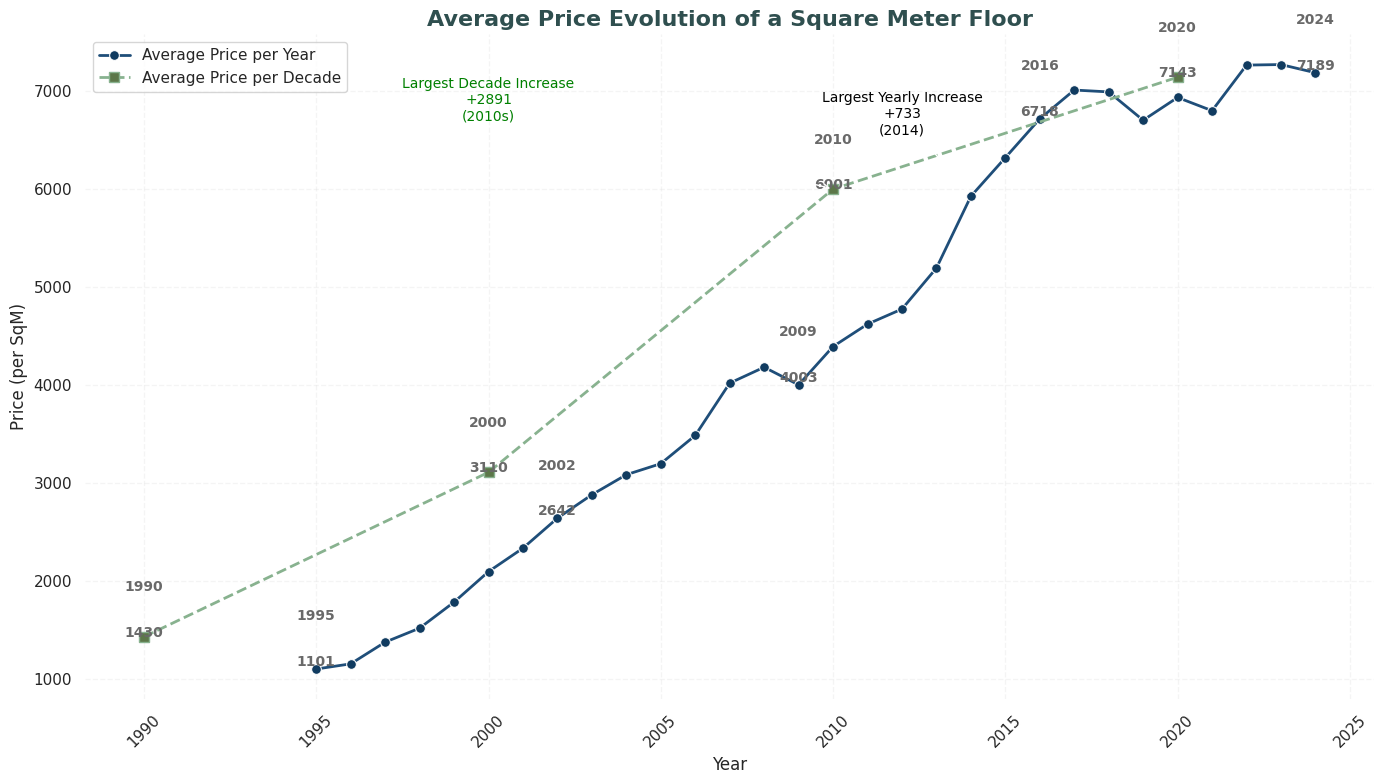

In [15]:
# Set seaborn theme for a minimalist and elegant style
sns.set_theme(style="white", palette="muted")

# Create a figure with adjusted layout
fig = plt.figure(constrained_layout=True, figsize=(14, 8))

# Define grid layout for the plots
ax1 = fig.add_subplot(111)  # Single subplot for combined graph

# --- Plot 1: Evolution of average price per year ---
yearly_data = df[df['saleEstimate_confidenceLevel'] == 'HIGH'].groupby('date_year')['price_SqM_historical'].mean().reset_index()

sns.lineplot(data=yearly_data, x='date_year', y='price_SqM_historical', ax=ax1, 
             color='#1f4e79', linewidth=2, marker='o', markersize=7, markerfacecolor='#103b60', label='Average Price per Year')

# --- Add mean line for each decade ---
decade_data = df[df['saleEstimate_confidenceLevel'] == 'HIGH'].groupby('decade')['price_SqM_historical'].mean().reset_index()

# Adiciona as médias por década
ax1.plot(decade_data['decade'], decade_data['price_SqM_historical'], color='#88b28f',linestyle='--', linewidth=2, marker='s', markersize=7, markerfacecolor='#5c7749', label='Average Price per Decade')

# Titles and labels
ax1.set_title('Average Price Evolution of a Square Meter Floor', size=16, color='darkslategray', weight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Price (per SqM)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Remove gridlines and borders from the plot
ax1.grid(True, linestyle='--', alpha=0.2)  # Discreet and smooth grid
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# --- Add labels at specific percentiles: 0%, 25%, 50%, 75%, and 100% ---
percentiles = [0, 0.25, 0.5, 0.75, 1]
marker_years = np.percentile(yearly_data['date_year'], [0, 25, 50, 75, 100])

# Add labels only for the specified percentiles (0%,  25%, 50%, 75%, and 100%)
for marker_year in marker_years:
    row = yearly_data[yearly_data['date_year'] == int(marker_year)].iloc[0]
    y_position = row['price_SqM_historical'] + 70  # Vertical offset for labels
    
    ax1.text(row['date_year'], y_position, f"{int(row['price_SqM_historical'])}", 
             color='dimgrey', ha='center', va='center', fontsize=10, fontweight='bold')
    # Add annotation directly above the point with more vertical space
    ax1.annotate(f'{int(row["date_year"])}', xy=(row['date_year'], y_position), 
                 xytext=(0, 30), textcoords='offset points', color='dimgrey',
                 ha='center', fontsize=10, fontweight='bold')

# --- Add labels for all points of the decade averages ---
for i, row in decade_data.iterrows():
    y_position = row['price_SqM_historical'] + 40  # Vertical offset for decade labels
    ax1.text(row['decade'], y_position, f"{int(row['price_SqM_historical'])}", 
             color='dimgrey', ha='center', va='center', fontsize=10, fontweight='bold')
    # Add annotation directly above the point with more vertical space
    ax1.annotate(f'{int(row["decade"])}', xy=(row['decade'], y_position),
                 xytext=(0, 30), textcoords='offset points', color='dimgrey',
                 ha='center', fontsize=10, fontweight='bold')

# --- Calculate and annotate the largest increases ---
# Largest yearly increase
yearly_data['yearly_diff'] = yearly_data['price_SqM_historical'].diff()
max_year_increase = yearly_data.loc[yearly_data['yearly_diff'].idxmax()]
ax1.annotate(
    f"Largest Yearly Increase\n+{int(max_year_increase['yearly_diff'])}\n({int(max_year_increase['date_year'])})", 
    xy=(max_year_increase['date_year'], max_year_increase['price_SqM_historical']), 
    xytext=(max_year_increase['date_year'] - 2, max_year_increase['price_SqM_historical'] + 630), 
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10, color='black', ha='center'
)

# Largest decade increase
decade_data['decade_diff'] = decade_data['price_SqM_historical'].diff()
max_decade_increase = decade_data.loc[decade_data['decade_diff'].idxmax()]
ax1.annotate(
    f"Largest Decade Increase\n+{int(max_decade_increase['decade_diff'])}\n({int(max_decade_increase['decade'])}s)", 
    xy=(max_decade_increase['decade'], max_decade_increase['price_SqM_historical']), 
    xytext=(max_decade_increase['decade'] - 10, max_decade_increase['price_SqM_historical'] + 700), 
    arrowprops=dict(facecolor='green', arrowstyle='->'),
    fontsize=10, color='green', ha='center'
)
# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


### Price Per Square Meter in London area: A Significant Increase

The line graph illustrates a substantial increase in the price per square meter in the **London area** over the years. In **1995**, the price was **£1101** per square meter, and by **2024**, it surged to **£7,189**. This represents a dramatic increase of **552%** over the 29-year period.

Looking at the data in terms of decades, we can see that the **1990s** began with an average price of **£1,430** per square meter. By the **2020s**, this price had skyrocketed to **£7,143**, showing an increase of over **399%** in just 30 years. 

## 6. Modeling 

### 6.1 Model creation (opting between two: linear and polynomial)

Degree: 1, MAE:189.85,MSE: 65739.23, R²:0.98
Degree: 2, MAE:244.44,MSE: 92867.68, R²:0.97
Best model: Degree 1


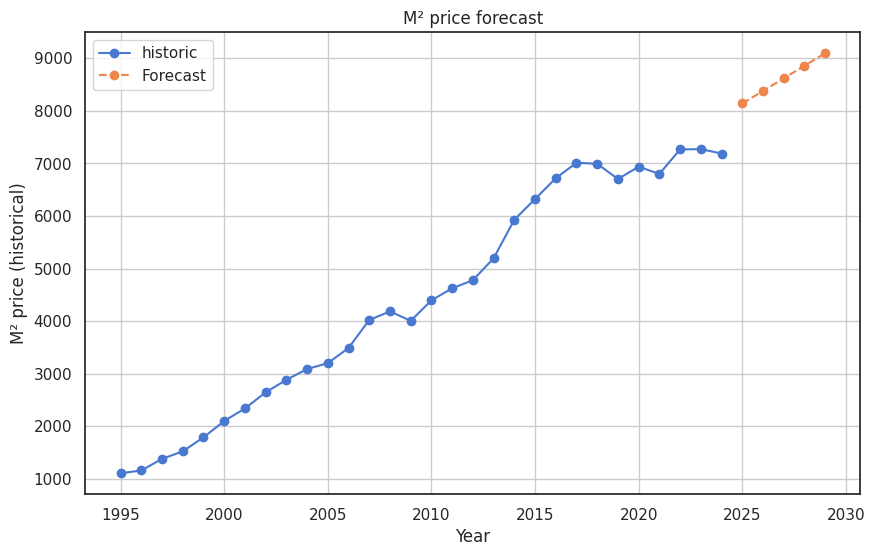

   date_year  price_SqM_projected
0       2025          8141.967098
1       2026          8381.028125
2       2027          8620.089151
3       2028          8859.150178
4       2029          9098.211204


In [16]:
future_years = np.arange(yearly_data['date_year'].max() + 1, yearly_data['date_year'].max() + 6).reshape(-1, 1)
X = yearly_data['date_year'].values.reshape(-1,1)
y = yearly_data['price_SqM_historical'].values
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=42)

degrees = [1,2]
best_model = None
best_degree = None
lowest_mae = float('inf')

for degree in degrees:
    if degree > 1:
        poly = PolynomialFeatures(degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        model = LinearRegression().fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)
    else:
        model = LinearRegression().fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)

    print(f'Degree: {degree}, MAE:{mae:.2f},MSE: {mse:.2f}, R²:{r2:.2f}')

    if mae < lowest_mae:
        lowest_mae = mae
        best_model = model
        best_degree = degree

print(f'Best model: Degree {best_degree}')

if best_degree > 1:
    poly = PolynomialFeatures(best_degree)
    X_fully_polly = poly.fit_transform(X)
    future_years_poly = poly.transform(future_years)
    future_prices = best_model.predict(future_years_poly)
else:
    future_prices = best_model.predict(future_years)
    

plt.figure(figsize=(10,6))
plt.plot(yearly_data['date_year'],yearly_data['price_SqM_historical'],label='historic',marker='o')
plt.plot(future_years,future_prices,label='Forecast',linestyle='--',marker='o')
plt.xlabel('Year')
plt.ylabel('M² price (historical)')
plt.title('M² price forecast')
plt.legend()
plt.grid()
plt.show()

future_data = pd.DataFrame({
    'date_year': future_years.flatten(),
    'price_SqM_projected': future_prices
})

print(future_data)

The forecast showed good results, with satisfactory projection scores, including a low MAE and a high R², indicating high accuracy and quality of the model's fit to the data. Therefore, we decided to keep the current model as the basis for future projections.

### 6.2 Feature importance

        Feature  Importance
0      postcode    0.937956
2  floorAreaSqM    0.045296
4  propertyType    0.006775
6      bedrooms    0.003992
1     bathrooms    0.003184
5   livingRooms    0.001968
3        tenure    0.000829


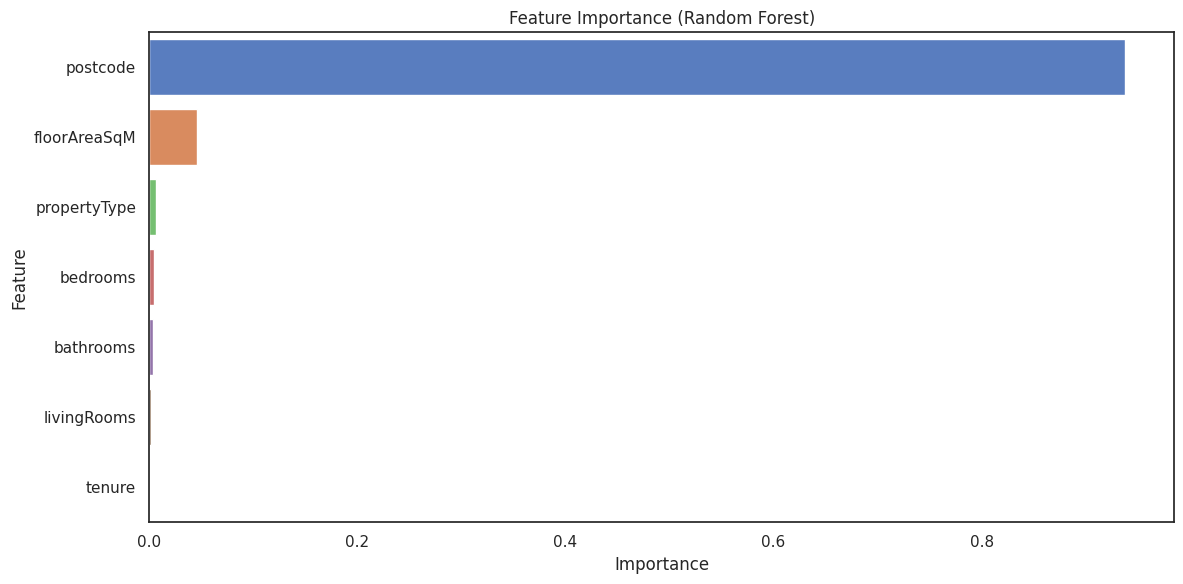

In [17]:
# Filter the DataFrame where saleEstimate_confidenceLevel is 'HIGH'
df_filtered = df[df['saleEstimate_confidenceLevel'] == 'HIGH']

# Define the independent variables (features) and the dependent variable (target)
features = ['postcode', 'bathrooms', 'floorAreaSqM', 'tenure', 'propertyType', 'livingRooms', 'bedrooms']
target = 'saleEstimate_currentPrice'

# Select the variables
X_filtered = df_filtered[features]
y_filtered = df_filtered[target]

# Transform categorical variables using Target Encoding
X_transformed = X_filtered.copy()

# Apply Target Encoding to 'postcode', 'tenure', and 'propertyType'
for col in ['postcode', 'tenure', 'propertyType']:
    col_mean_target = df_filtered.groupby(col)[target].mean()
    X_transformed[col] = X_transformed[col].map(col_mean_target)

# Initialize the Random Forest model with a reduced number of trees
rfr = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)  # Reduced n_estimators to use less memory
rfr.fit(X_transformed, y_filtered)

# Calculate feature importance
importances = rfr.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_transformed.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance)

# Plot the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


 The analysis indicates that the most important features are the postcodes and the floor area (sqm) of the apartments, highlighting their significant influence on the property price estimation.

## 7. Conclusion 

Our projection shows a continuous rise in the **price per square meter** in the London area, growing from an average of **£1101** in **1995** to **£7,189** in **2024**. This marks an impressive increase of **552%** over the past 29 years.

When we look at the **average salary** in the UK, it paints a different picture. In **1995**, the typical full-time worker earned around **£17,000** annually. By **2024**, this had risen to roughly **£37,430**. Showing an increase of **120%**. 
*Source: [STATISTA](https://www.statista.com/statistics/1002964/average-full-time-annual-earnings-in-the-uk/?utm_source=chatgpt.com)*

Looking at **inflation**, the UK's rate in **1995** was about **2.70%**. Over the years, inflation accumulated at an astonishing rate of **2,198.21%**, meaning an item that cost **£100** in **1990** would now cost roughly **£2,198.21** in **2024**.  
*Source: [MACROTRENDS](https://www.macrotrends.net/global-metrics/countries/gbr/united-kingdom/inflation-rate-cpi?utm_source=chatgpt.com)*

While both property prices and salaries have increased over this period, it's clear that property prices have risen far more sharply than salaries or inflation. This growing gap suggests that housing in London is becoming increasingly out of reach for many people, underscoring the need for policies that address housing affordability in the city.

